In [20]:
# Import Required Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Neural Network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
# Data Loading and Preprocessing

# Load the dataset
df = pd.read_csv('data/Wifi_train_dataset.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

# Parse RSSI and MAC address strings into lists
rssi_lists = df['rssi'].apply(lambda x: [float(v) for v in x.split(',')])
mac_lists = df['mac_addrs_idx'].apply(lambda x: [int(v) for v in x.split(',')])

# Find all unique MAC addresses to create fixed-length feature space
all_macs = set()
for mac_list in mac_lists:
    all_macs.update(mac_list)
all_macs = sorted(list(all_macs))
n_macs = len(all_macs)

print(f"\nFound {n_macs} unique MAC addresses (access points)")

# Create mapping from MAC address to column index
mac_to_idx = {mac: idx for idx, mac in enumerate(all_macs)}

# Create fixed-length feature matrix (one column per MAC address)
n_samples = len(df)
X = np.full((n_samples, n_macs), np.nan)  # Initialize with NaN

for i in range(n_samples):
    rssi_vals = rssi_lists.iloc[i]
    mac_vals = mac_lists.iloc[i]
    
    # Populate feature vector at correct MAC positions
    for rssi, mac in zip(rssi_vals, mac_vals):
        col_idx = mac_to_idx[mac]
        X[i, col_idx] = rssi

print(f"\nCreated feature matrix: {X.shape}")
print(f"NaN values: {np.isnan(X).sum():,} ({100 * np.isnan(X).sum() / X.size:.2f}% of total)")

# Impute with -100 dB (no signal indicator)
X_imputed = np.nan_to_num(X, nan=-100.0)
print(f"Imputed NaN values with -100 dB (no signal indicator)")

# Remove low-variance features (APs that are almost always -100)
print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)
variance_threshold = VarianceThreshold(threshold=1.0)
X_selected = variance_threshold.fit_transform(X_imputed)
n_features_removed = n_macs - X_selected.shape[1]

print(f"Removed {n_features_removed} low-variance features")
print(f"Remaining features: {X_selected.shape[1]}")

# Add engineered features
print("\nAdding engineered features...")

# Feature 1: Number of APs detected (non -100 values)
n_aps_detected = np.sum(X_imputed > -100, axis=1).reshape(-1, 1)

# Feature 2: Mean RSSI of detected APs
mean_rssi = np.zeros((n_samples, 1))
for i in range(n_samples):
    detected = X_imputed[i, X_imputed[i] > -100]
    mean_rssi[i] = detected.mean() if len(detected) > 0 else -100

# Feature 3: Max RSSI (strongest signal)
max_rssi = np.max(X_imputed, axis=1).reshape(-1, 1)

# Feature 4: Std of detected RSSI values
std_rssi = np.zeros((n_samples, 1))
for i in range(n_samples):
    detected = X_imputed[i, X_imputed[i] > -100]
    std_rssi[i] = detected.std() if len(detected) > 1 else 0

# Combine original features with engineered features
X_enhanced = np.hstack([X_selected, n_aps_detected, mean_rssi, max_rssi, std_rssi])

print(f"Added 4 engineered features")
print(f"Total features: {X_enhanced.shape[1]}")
print(f"  - Number of APs detected")
print(f"  - Mean RSSI of detected APs")
print(f"  - Maximum RSSI (strongest signal)")
print(f"  - Standard deviation of RSSI")

# Prepare targets
y = df[['x', 'y']]

# ------------------------------------------------------------
# Train / Validation / Test split
# - Train: used for gradient updates / fitting models
# - Val:   used for early stopping + LR scheduling + model selection
# - Test:  held-out final reporting only
# ------------------------------------------------------------

# First split off a held-out test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_enhanced, y, test_size=0.15, random_state=42
 )

# Then split the remaining into train and validation
# val_size is relative to the remaining (85%) so that overall val is 15%
val_size = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=val_size, random_state=42
 )

print(f"\nTraining set size:   {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size:       {X_test.shape[0]}")

# Feature Scaling
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Training features shape:   {X_train_scaled.shape}")
print(f"Validation features shape: {X_val_scaled.shape}")
print(f"Test features shape:       {X_test_scaled.shape}")
print("="*60)

Dataset shape: (2880, 4)

First few rows:
           x          y                                               rssi  \
0  39.300458 -33.832626  -76,-84,-76,-78,-76,-79,-79,-76,-83,-46,-46,-4...   
1  45.667780 -17.235028  -81,-82,-82,-82,-65,-65,-65,-65,-71,-71,-71,-7...   
2  79.944219 -54.821975  -88,-88,-88,-88,-78,-78,-78,-78,-67,-66,-66,-6...   
3  57.353449 -30.499641  -88,-91,-91,-61,-61,-61,-62,-88,-92,-92,-79,-9...   
4  54.454364 -16.056419  -84,-88,-84,-88,-84,-88,-84,-88,-83,-82,-82,-8...   

                                       mac_addrs_idx  
0  68,251,65,46,66,47,48,78,183,95,96,97,143,212,...  
1  126,127,128,129,59,56,57,60,86,85,58,87,120,12...  
2  1,2,3,4,290,289,288,291,5,6,7,8,23,21,152,154,...  
3  113,114,115,1,2,3,4,184,185,186,78,76,119,81,5...  
4  45,68,46,65,47,66,48,78,95,98,96,97,59,56,57,6...  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dt

In [22]:
# Task i: Multi-Linear Regression Model

print("="*60)
print("TASK i: DEVELOPING MULTI-LINEAR REGRESSION MODEL")
print("="*60)

# Build separate models for X and Y coordinates
model_x = LinearRegression()
model_y = LinearRegression()

# Train the models on scaled training data
model_x.fit(X_train_scaled, y_train['x'])
model_y.fit(X_train_scaled, y_train['y'])

print("\n✓ Models trained successfully!")
print(f"  Model X: {len(model_x.coef_)} coefficients, Intercept: {model_x.intercept_:.4f}")
print(f"  Model Y: {len(model_y.coef_)} coefficients, Intercept: {model_y.intercept_:.4f}")
print("="*60)

TASK i: DEVELOPING MULTI-LINEAR REGRESSION MODEL

✓ Models trained successfully!
  Model X: 511 coefficients, Intercept: 48.8390
  Model Y: 511 coefficients, Intercept: -27.3522


TASK ii: MODEL PERFORMANCE ON TEST SET (HELD-OUT)

Mean Squared Error (X coordinate): 17.8129
Mean Squared Error (Y coordinate): 22.8906

>>> Overall Mean Squared Error: 20.3518 <<<

Additional Metrics:
  RMSE (X coordinate): 4.2205
  RMSE (Y coordinate): 4.7844
  Overall RMSE: 4.5113

  R² Score (X coordinate): 0.9094
  R² Score (Y coordinate): 0.7885

------------------------------------------------------------
Sample Predictions vs Actual Values (First 5)
------------------------------------------------------------
 Actual_X  Predicted_X  Error_X   Actual_Y  Predicted_Y  Error_Y
59.779089    57.948734 1.830355 -30.530006   -34.122801 3.592795
55.781606    60.098527 4.316921 -18.976056   -22.212363 3.236307
30.571793    27.496453 3.075341 -37.548512   -41.851572 4.303060
39.217118    35.617642 3.599475 -34.819949   -31.747302 3.072647
51.736434    49.200057 2.536377 -33.385827   -27.975928 5.409898

Generating visualization...


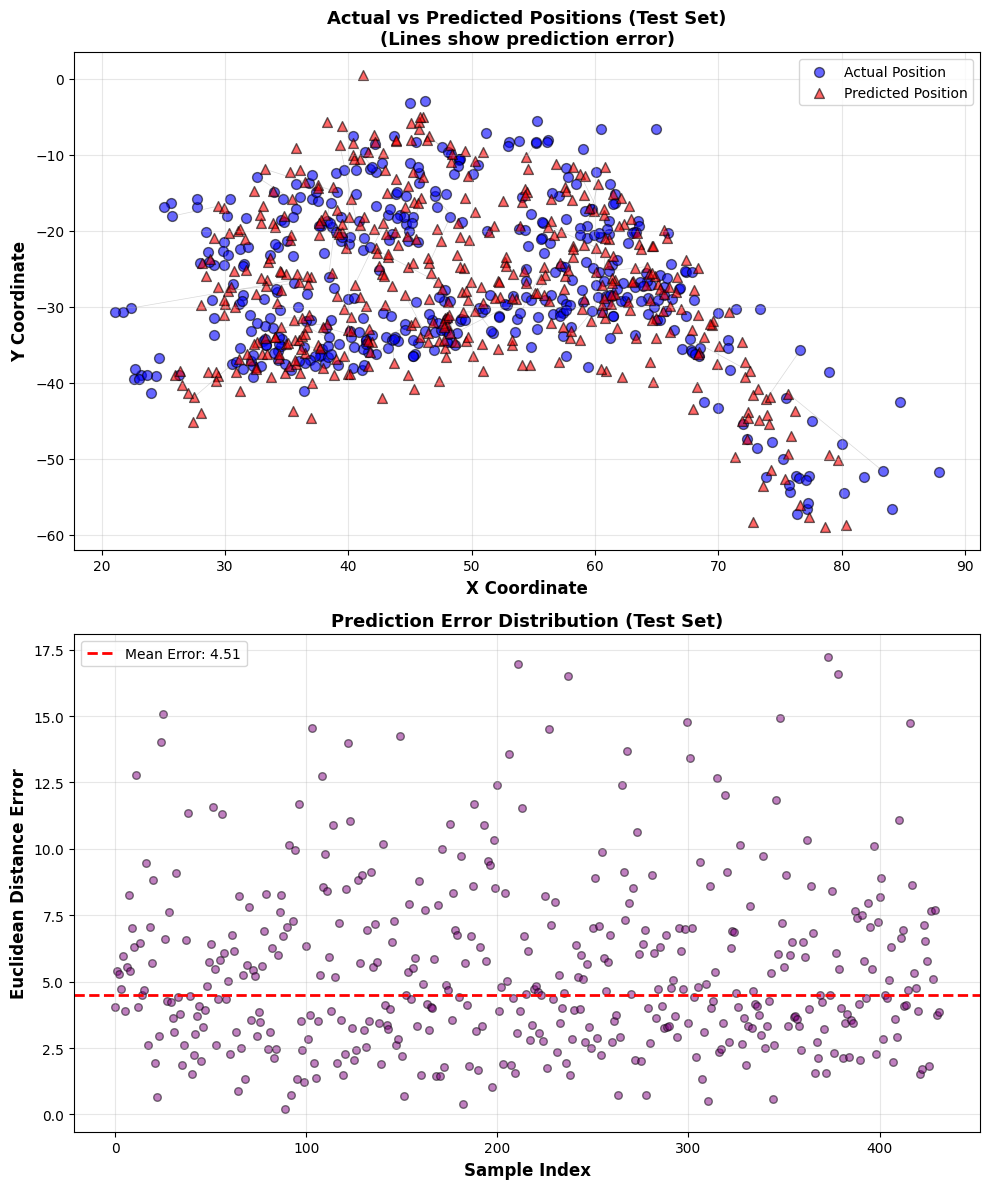

✓ Visualization complete!


In [23]:
# Task ii: Report Model Performance on Held-out Test Set

print("="*60)
print("TASK ii: MODEL PERFORMANCE ON TEST SET (HELD-OUT)")
print("="*60)

# Make predictions on test set
y_pred_x = model_x.predict(X_test_scaled)
y_pred_y = model_y.predict(X_test_scaled)

# Calculate Mean Squared Error for each coordinate
mse_x = mean_squared_error(y_test['x'], y_pred_x)
mse_y = mean_squared_error(y_test['y'], y_pred_y)

# Calculate overall MSE (average of both coordinates)
mse_overall = (mse_x + mse_y) / 2

print(f"\nMean Squared Error (X coordinate): {mse_x:.4f}")
print(f"Mean Squared Error (Y coordinate): {mse_y:.4f}")
print(f"\n>>> Overall Mean Squared Error: {mse_overall:.4f} <<<")
print("="*60)

# Additional metrics
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_overall = np.sqrt(mse_overall)

print(f"\nAdditional Metrics:")
print(f"  RMSE (X coordinate): {rmse_x:.4f}")
print(f"  RMSE (Y coordinate): {rmse_y:.4f}")
print(f"  Overall RMSE: {rmse_overall:.4f}")

# Calculate R² scores
r2_x = r2_score(y_test['x'], y_pred_x)
r2_y = r2_score(y_test['y'], y_pred_y)

print(f"\n  R² Score (X coordinate): {r2_x:.4f}")
print(f"  R² Score (Y coordinate): {r2_y:.4f}")

# Display some sample predictions
print("\n" + "-"*60)
print("Sample Predictions vs Actual Values (First 5)")
print("-"*60)
comparison = pd.DataFrame({
    'Actual_X': y_test['x'].values[:5],
    'Predicted_X': y_pred_x[:5],
    'Error_X': np.abs(y_test['x'].values[:5] - y_pred_x[:5]),
    'Actual_Y': y_test['y'].values[:5],
    'Predicted_Y': y_pred_y[:5],
    'Error_Y': np.abs(y_test['y'].values[:5] - y_pred_y[:5])
})
print(comparison.to_string(index=False))
print("="*60)

# Visualization: Predicted vs Actual Positions
print("\nGenerating visualization...")

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot 1: 2D Position Scatter (Actual vs Predicted)
ax1 = axes[0]
ax1.scatter(y_test['x'], y_test['y'], alpha=0.6, s=50, c='blue', label='Actual Position', edgecolors='black')
ax1.scatter(y_pred_x, y_pred_y, alpha=0.6, s=50, c='red', marker='^', label='Predicted Position', edgecolors='black')

# Draw lines connecting actual to predicted for first 50 points (to avoid clutter)
for i in range(min(50, len(y_test))):
    ax1.plot([y_test['x'].values[i], y_pred_x[i]], 
             [y_test['y'].values[i], y_pred_y[i]], 
             'gray', alpha=0.3, linewidth=0.5)

ax1.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax1.set_title('Actual vs Predicted Positions (Test Set)\n(Lines show prediction error)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Residual Plot
ax2 = axes[1]
errors = np.sqrt((y_test['x'].values - y_pred_x)**2 + (y_test['y'].values - y_pred_y)**2)
ax2.scatter(range(len(errors)), errors, alpha=0.5, s=30, c='purple', edgecolors='black')
ax2.axhline(y=rmse_overall, color='red', linestyle='--', linewidth=2, label=f'Mean Error: {rmse_overall:.2f}')
ax2.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Euclidean Distance Error', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error Distribution (Test Set)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

EXPLORING MODEL IMPROVEMENTS WITH ELASTICNET

ElasticNet combines Ridge (L2) and Lasso (L1) regularization
to balance feature selection with stability.

Training ElasticNet models with cross-validation...
✓ Best alpha for X: 0.10, L1 ratio: 0.50
✓ Best alpha for Y: 0.10, L1 ratio: 0.50

ElasticNet MSE (X) on test: 17.3328
ElasticNet MSE (Y) on test: 19.6505
ElasticNet Overall MSE on test: 18.4917

ElasticNet selected 246/511 features for X
ElasticNet selected 256/511 features for Y

COMPARISON (TEST SET): Linear Regression vs ElasticNet
Model                          MSE (X)         MSE (Y)         Overall MSE    
---------------------------------------------------------------------------
Linear Regression              17.8129         22.8906         20.3518        
ElasticNet                     17.3328         19.6505         18.4917        

✓ Improvement: 9.14% reduction in MSE
✓ ElasticNet achieved better generalization through regularization


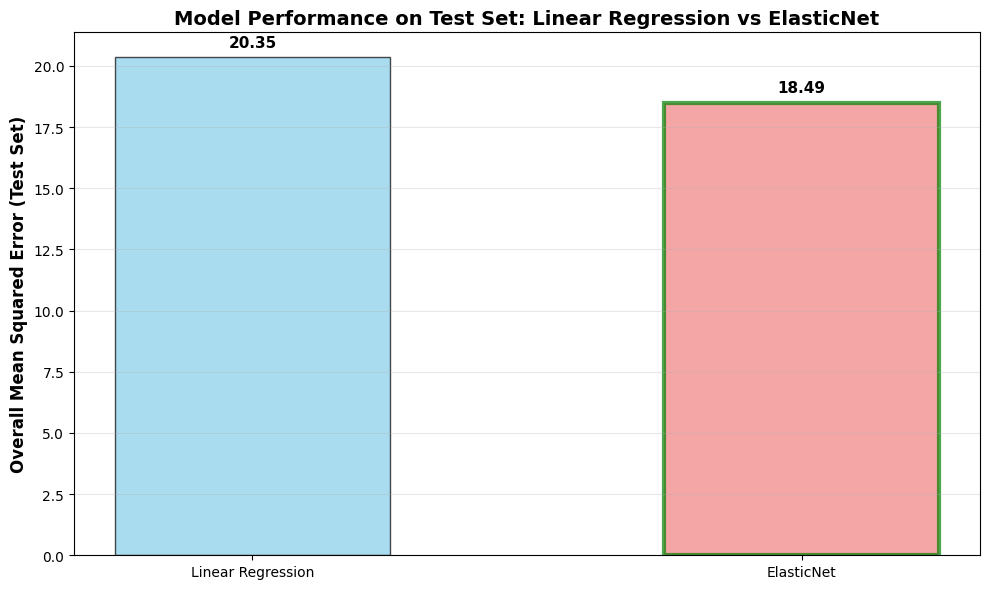


💡 Key Insight:
   ElasticNet's hybrid L1+L2 regularization reduces overfitting
   by performing feature selection while maintaining stability.


In [24]:
# Potential Improvement: ElasticNet with Cross-Validation

print("="*60)
print("EXPLORING MODEL IMPROVEMENTS WITH ELASTICNET")
print("="*60)

print("\nElasticNet combines Ridge (L2) and Lasso (L1) regularization")
print("to balance feature selection with stability.\n")

# Define range of alpha values to test
alphas = np.logspace(-2, 3, 50)

# ElasticNet with cross-validation
print("Training ElasticNet models with cross-validation...")
elastic_cv_x = ElasticNetCV(alphas=alphas, cv=5, max_iter=10000, l1_ratio=[0.1, 0.5, 0.7, 0.9])
elastic_cv_y = ElasticNetCV(alphas=alphas, cv=5, max_iter=10000, l1_ratio=[0.1, 0.5, 0.7, 0.9])

elastic_cv_x.fit(X_train_scaled, y_train['x'])
elastic_cv_y.fit(X_train_scaled, y_train['y'])

print(f"✓ Best alpha for X: {elastic_cv_x.alpha_:.2f}, L1 ratio: {elastic_cv_x.l1_ratio_:.2f}")
print(f"✓ Best alpha for Y: {elastic_cv_y.alpha_:.2f}, L1 ratio: {elastic_cv_y.l1_ratio_:.2f}")

# Make predictions on held-out test set
y_pred_elastic_x = elastic_cv_x.predict(X_test_scaled)
y_pred_elastic_y = elastic_cv_y.predict(X_test_scaled)

# Calculate MSE on test set
mse_elastic_x = mean_squared_error(y_test['x'], y_pred_elastic_x)
mse_elastic_y = mean_squared_error(y_test['y'], y_pred_elastic_y)
mse_elastic_overall = (mse_elastic_x + mse_elastic_y) / 2

print(f"\nElasticNet MSE (X) on test: {mse_elastic_x:.4f}")
print(f"ElasticNet MSE (Y) on test: {mse_elastic_y:.4f}")
print(f"ElasticNet Overall MSE on test: {mse_elastic_overall:.4f}")

# Count non-zero coefficients (feature selection)
non_zero_elastic_x = np.sum(elastic_cv_x.coef_ != 0)
non_zero_elastic_y = np.sum(elastic_cv_y.coef_ != 0)
print(f"\nElasticNet selected {non_zero_elastic_x}/{len(elastic_cv_x.coef_)} features for X")
print(f"ElasticNet selected {non_zero_elastic_y}/{len(elastic_cv_y.coef_)} features for Y")

# Compare with baseline (both evaluated on test set)
print("\n" + "="*60)
print("COMPARISON (TEST SET): Linear Regression vs ElasticNet")
print("="*60)
print(f"{'Model':<30} {'MSE (X)':<15} {'MSE (Y)':<15} {'Overall MSE':<15}")
print("-"*75)
print(f"{'Linear Regression':<30} {mse_x:<15.4f} {mse_y:<15.4f} {mse_overall:<15.4f}")
print(f"{'ElasticNet':<30} {mse_elastic_x:<15.4f} {mse_elastic_y:<15.4f} {mse_elastic_overall:<15.4f}")
print("="*60)

improvement = ((mse_overall - mse_elastic_overall) / mse_overall) * 100
print(f"\n✓ Improvement: {improvement:.2f}% reduction in MSE")
print(f"✓ ElasticNet achieved better generalization through regularization")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Linear Regression', 'ElasticNet']
mse_values = [mse_overall, mse_elastic_overall]
colors = ['skyblue', 'lightcoral']

bars = ax.bar(models, mse_values, color=colors, edgecolor='black', alpha=0.7, width=0.5)

# Highlight best model
best_idx = mse_values.index(min(mse_values))
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(3)

ax.set_ylabel('Overall Mean Squared Error (Test Set)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance on Test Set: Linear Regression vs ElasticNet', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(mse_values):
    ax.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   ElasticNet's hybrid L1+L2 regularization reduces overfitting")
print("   by performing feature selection while maintaining stability.")

## 2.2 Neural Network Model for Indoor Localization

In [25]:
# Task i: Define Neural Network Architecture (baseline only)

print("="*60)
print("SECTION 2.2 - TASK i: NEURAL NETWORK MODEL DEFINITION")
print("="*60)

# Best hyperparameters found via grid-search
BEST_CFG = {
    'lr': 1e-3,
    'l2': 3e-4,
    'dropout': (0.2, 0.2, 0.1),
    'batch_size': 64,
    'huber_delta': 1.0,
    'max_epochs': 150,
    'es_patience': 12,
    'rlr_patience': 6,
}

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.preprocessing import StandardScaler as _SkStandardScaler

# Scale targets too (often stabilizes optimization for coordinate regression)
y_scaler = _SkStandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

def create_deep_nn_with_batchnorm(input_dim, l2, dropout):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout[0]),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout[1]),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout[2]),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(2, activation='linear')
    ], name='Deep_NN_BatchNorm')
    return model

def compile_model(model, lr, huber_delta):
    # Huber is often more robust than MSE when there are a few hard-to-predict points
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Huber(delta=huber_delta),
        metrics=[keras.metrics.MeanSquaredError(name='mse'), keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

# Create the baseline model (using BEST_CFG defaults)
input_dim = X_train_scaled.shape[1]
nn_model = create_deep_nn_with_batchnorm(
    input_dim=input_dim,
    l2=BEST_CFG['l2'],
    dropout=BEST_CFG['dropout'],
)
nn_model = compile_model(nn_model, lr=BEST_CFG['lr'], huber_delta=BEST_CFG['huber_delta'])

print("\n✓ Neural Network Model Created! (tuned)")
print(f"  Input Features: {input_dim}")
print(f"  lr={BEST_CFG['lr']}, l2={BEST_CFG['l2']}, dropout={BEST_CFG['dropout']}, batch={BEST_CFG['batch_size']}")
print(f"  Total Parameters: {nn_model.count_params():,}")
print("="*60)

SECTION 2.2 - TASK i: NEURAL NETWORK MODEL DEFINITION

✓ Neural Network Model Created! (tuned)
  Input Features: 511
  lr=0.001, l2=0.0003, dropout=(0.2, 0.2, 0.1), batch=64
  Total Parameters: 438,338


In [26]:
# Task ii: Train Neural Network (baseline only, tuned params)

print("="*60)
print("SECTION 2.2 - TASK ii: TRAINING NEURAL NETWORK")
print("="*60)

# Define callbacks for training (from BEST_CFG)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=BEST_CFG['es_patience'],
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=BEST_CFG['rlr_patience'],
    min_lr=1e-6,
    verbose=1
)

print("\nTraining Configuration:")
print("-" * 60)
print(f"  • Optimizer: Adam (lr={BEST_CFG['lr']})")
print(f"  • Loss Function: Huber (delta={BEST_CFG['huber_delta']})")
print(f"  • Batch Size: {BEST_CFG['batch_size']}")
print(f"  • Max Epochs: {BEST_CFG['max_epochs']}")
print(f"  • Early Stopping: Patience={BEST_CFG['es_patience']}, monitor=val_loss")
print(f"  • ReduceLROnPlateau: factor=0.5, patience={BEST_CFG['rlr_patience']}")
print("="*60)

print("\n🚀 Training tuned model (scaled y)...\n")
history = nn_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=BEST_CFG['max_epochs'],
    batch_size=BEST_CFG['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ Training complete!")
print("="*60)

SECTION 2.2 - TASK ii: TRAINING NEURAL NETWORK

Training Configuration:
------------------------------------------------------------
  • Optimizer: Adam (lr=0.001)
  • Loss Function: Huber (delta=1.0)
  • Batch Size: 64
  • Max Epochs: 150
  • Early Stopping: Patience=12, monitor=val_loss
  • ReduceLROnPlateau: factor=0.5, patience=6

🚀 Training tuned model (scaled y)...

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.6583 - mae: 0.6658 - mse: 0.7791 - val_loss: 0.6929 - val_mae: 0.7173 - val_mse: 0.8810 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4791 - mae: 0.4265 - mse: 0.3089 - val_loss: 0.5108 - val_mae: 0.4890 - val_mse: 0.3836 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4428 - mae: 0.3685 - mse: 0.2355 - val_loss: 0.4435 - val_mae: 0.3792 - val_mse: 0.2421 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4176 - mae: 0.3349 - mse: 0.1908 - val_los

SECTION 2.2 - TASK iii: TEST RESULTS & COMPARISON (HELD-OUT)

Neural Network Test Results:
------------------------------------------------------------
Overall MSE:  7.6188
Overall RMSE: 2.7602
R² (X): 0.9591
R² (Y): 0.9335

Euclidean Position Error (NN, test set):
------------------------------------------------------------
Mean:   3.1405
Median: 2.6443
P90:    5.5545
P95:    7.5929
Max:    15.0888

Mean Percentage Error (MPE, test set):
------------------------------------------------------------
MPE (fraction): 0.069405
MPE (%):        6.9405%

COMPARISON (TEST SET): Linear Regression vs Neural Network
Model                          Overall MSE     Overall RMSE   
------------------------------------------------------------
Linear Regression              20.3518         4.5113         
Neural Network                 7.6188          2.7602         

Generating visualizations...


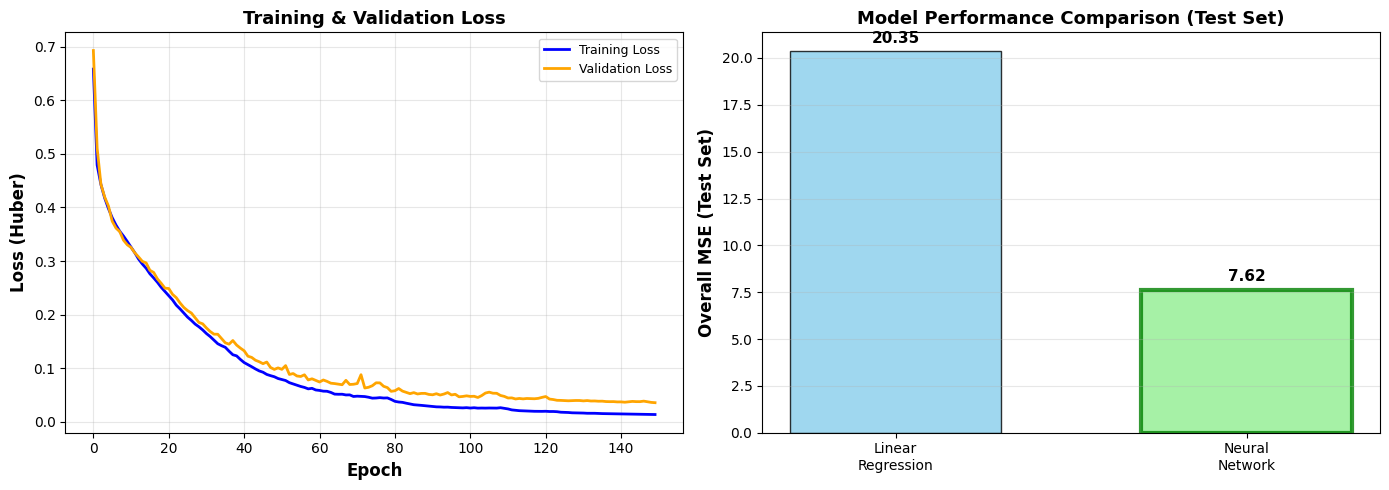


✓ Visualizations complete!


In [35]:
# Task iii: Neural Network Test Results & Comparison with Linear Regression

print("="*60)
print("SECTION 2.2 - TASK iii: TEST RESULTS & COMPARISON (HELD-OUT)")
print("="*60)

# Predict on held-out test set (predictions are in scaled coordinate space)
y_pred_nn_scaled = nn_model.predict(X_test_scaled, verbose=0)

# Inverse-transform back to original coordinate units
y_pred_nn = y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_nn_x = y_pred_nn[:, 0]
y_pred_nn_y = y_pred_nn[:, 1]

# Calculate MSE/RMSE/R2 on test set
nn_mse_x = mean_squared_error(y_test['x'], y_pred_nn_x)
nn_mse_y = mean_squared_error(y_test['y'], y_pred_nn_y)
nn_mse_overall = (nn_mse_x + nn_mse_y) / 2

nn_rmse_overall = float(np.sqrt(nn_mse_overall))
nn_r2_x = r2_score(y_test['x'], y_pred_nn_x)
nn_r2_y = r2_score(y_test['y'], y_pred_nn_y)

# Euclidean position error (more interpretable for localization)
nn_pos_err = np.sqrt((y_test['x'].values - y_pred_nn_x) ** 2 + (y_test['y'].values - y_pred_nn_y) ** 2)
nn_pos_err_mean = float(np.mean(nn_pos_err))
nn_pos_err_median = float(np.median(nn_pos_err))
nn_pos_err_p90 = float(np.percentile(nn_pos_err, 90))
nn_pos_err_p95 = float(np.percentile(nn_pos_err, 95))
nn_pos_err_max = float(np.max(nn_pos_err))

# Mean Percentage Error (MPE) on test set
# MPE = (1/M) * sum_i 0.5 * ( |xhat - x|/|x| + |yhat - y|/|y| )
eps = 1e-8
x_true = y_test['x'].values
y_true = y_test['y'].values
mpe_per_sample = 0.5 * (
    np.abs(y_pred_nn_x - x_true) / np.maximum(np.abs(x_true), eps)
    + np.abs(y_pred_nn_y - y_true) / np.maximum(np.abs(y_true), eps)
 )
mpe = float(np.mean(mpe_per_sample))
mpe_pct = 100.0 * mpe

print("\nNeural Network Test Results:")
print("-" * 60)
print(f"Overall MSE:  {nn_mse_overall:.4f}")
print(f"Overall RMSE: {nn_rmse_overall:.4f}")
print(f"R² (X): {nn_r2_x:.4f}")
print(f"R² (Y): {nn_r2_y:.4f}")

print("\nEuclidean Position Error (NN, test set):")
print("-" * 60)
print(f"Mean:   {nn_pos_err_mean:.4f}")
print(f"Median: {nn_pos_err_median:.4f}")
print(f"P90:    {nn_pos_err_p90:.4f}")
print(f"P95:    {nn_pos_err_p95:.4f}")
print(f"Max:    {nn_pos_err_max:.4f}")

print("\nMean Percentage Error (MPE, test set):")
print("-" * 60)
print(f"MPE (fraction): {mpe:.6f}")
print(f"MPE (%):        {mpe_pct:.4f}%")

# Compare with Linear Regression (also evaluated on test set)
print("\n" + "="*60)
print("COMPARISON (TEST SET): Linear Regression vs Neural Network")
print("="*60)
print(f"{'Model':<30} {'Overall MSE':<15} {'Overall RMSE':<15}")
print("-"*60)
print(f"{'Linear Regression':<30} {mse_overall:<15.4f} {rmse_overall:<15.4f}")
print(f"{'Neural Network':<30} {nn_mse_overall:<15.4f} {nn_rmse_overall:<15.4f}")
print("="*60)

# Visualize training history and comparison
print("\nGenerating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss (Huber)', fontsize=12, fontweight='bold')
ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
models = ['Linear\nRegression', 'Neural\nNetwork']
mse_values = [mse_overall, nn_mse_overall]
colors = ['skyblue', 'lightgreen']
bars = ax2.bar(models, mse_values, color=colors, edgecolor='black', alpha=0.8, width=0.6)
best_idx = mse_values.index(min(mse_values))
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(3)
ax2.set_ylabel('Overall MSE (Test Set)', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison (Test Set)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(mse_values):
    ax2.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete!")
print("="*60)

## 2.3 Final Improvement: NN + Boosting Ensemble (Validation-tuned)

The best performing improvement is a **simple ensemble** that blends:
- the **Neural Network** (good at learning smooth, non-linear mappings), and
- a **Histogram Gradient Boosting** regressor (strong tabular baseline that can capture different non-linearities).

### What this cell does
- Computes NN predictions on **validation** and **test** (inverse-transformed back to original $(x,y)$ units).
- Fits boosting models on **train only** to produce **honest validation predictions**.
- Tunes the blend weight $\alpha$ on the validation set, where:

$$\hat{y} = \alpha \cdot \hat{y}_{NN} + (1-\alpha) \cdot \hat{y}_{Boost}$$

- Refits boosting on **train + validation** and evaluates the final ensemble **once** on the held-out test set.

### Why this is fair (no leakage)
Validation is used only to choose $\alpha$ (model selection). The **test set is not used** until the final evaluation.


In [43]:
# Final Improvement: Ensemble (Neural Network + Boosting)
# - Tune blend weight alpha on validation
# - Refit boosting on train+val
# - Evaluate ensemble once on held-out test

import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

print("="*60)
print("FINAL IMPROVEMENT: NN + Boosting Ensemble")
print("="*60)

# Sanity checks: these should exist from earlier baseline cells
assert 'nn_model' in globals(), "Run the baseline NN training cell first."
assert 'y_scaler' in globals(), "Run the baseline target-scaling cell first."

# 1) NN predictions on validation and test (back to original coordinates)
val_nn_scaled = nn_model.predict(X_val_scaled, verbose=0)
val_nn = y_scaler.inverse_transform(val_nn_scaled)

test_nn_scaled = nn_model.predict(X_test_scaled, verbose=0)
test_nn = y_scaler.inverse_transform(test_nn_scaled)

# 2) Boosting configuration (kept fixed + simple)
# Chosen from prior validation sweep; good default for this dataset.
boost_cfg = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'max_leaf_nodes': 31,
    'min_samples_leaf': 20,
    'l2_regularization': 0.1,
}

# Train boosting on TRAIN only -> honest validation predictions
mx_tr = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
my_tr = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
mx_tr.fit(X_train_scaled, y_train['x'].values)
my_tr.fit(X_train_scaled, y_train['y'].values)

val_boost = np.column_stack([
    mx_tr.predict(X_val_scaled),
    my_tr.predict(X_val_scaled),
])

# Train boosting on TRAIN+VAL -> final test prediction
X_tv = np.vstack([X_train_scaled, X_val_scaled])
y_tv_x = np.concatenate([y_train['x'].values, y_val['x'].values])
y_tv_y = np.concatenate([y_train['y'].values, y_val['y'].values])

mx_tv = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
my_tv = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
mx_tv.fit(X_tv, y_tv_x)
my_tv.fit(X_tv, y_tv_y)

test_boost = np.column_stack([
    mx_tv.predict(X_test_scaled),
    my_tv.predict(X_test_scaled),
])

# 3) Tune alpha on validation
# pred = alpha * NN + (1-alpha) * Boost
alphas = np.round(np.arange(0.0, 1.0001, 0.05), 2)

y_val_xy = y_val[['x', 'y']].values
y_test_xy = y_test[['x', 'y']].values

best_alpha = None
best_val_mse = None

for a in alphas:
    pv = a * val_nn + (1.0 - a) * val_boost
    mse_x = mean_squared_error(y_val_xy[:, 0], pv[:, 0])
    mse_y = mean_squared_error(y_val_xy[:, 1], pv[:, 1])
    mse_overall = (mse_x + mse_y) / 2
    if (best_val_mse is None) or (mse_overall < best_val_mse):
        best_val_mse = float(mse_overall)
        best_alpha = float(a)

print("Boost cfg:")
print(boost_cfg)
print(f"\nSelected alpha (by val): {best_alpha} (val overall MSE={best_val_mse:.4f})")

# 4) Evaluate ensemble once on test
pt = best_alpha * test_nn + (1.0 - best_alpha) * test_boost

ens_mse_x = mean_squared_error(y_test_xy[:, 0], pt[:, 0])
ens_mse_y = mean_squared_error(y_test_xy[:, 1], pt[:, 1])
ens_mse_overall = (ens_mse_x + ens_mse_y) / 2
ens_rmse_overall = float(np.sqrt(ens_mse_overall))

pos_err = np.sqrt((y_test_xy[:, 0] - pt[:, 0])**2 + (y_test_xy[:, 1] - pt[:, 1])**2)

eps = 1e-8
mpe_ens = float(np.mean(0.5 * (
    np.abs(pt[:, 0] - y_test_xy[:, 0]) / np.maximum(np.abs(y_test_xy[:, 0]), eps)
    + np.abs(pt[:, 1] - y_test_xy[:, 1]) / np.maximum(np.abs(y_test_xy[:, 1]), eps)
)))

print("\nEnsemble TEST results:")
print("-" * 60)
print(f"Overall MSE:  {ens_mse_overall:.4f}")
print(f"Overall RMSE: {ens_rmse_overall:.4f}")
print(f"Euclid mean/median: {float(np.mean(pos_err)):.4f} / {float(np.median(pos_err)):.4f}")
print(f"Euclid P90/P95:     {float(np.percentile(pos_err, 90)):.4f} / {float(np.percentile(pos_err, 95)):.4f}")
print(f"MPE (%):            {100.0 * mpe_ens:.4f}%")

print("\n" + "="*60)
print("COMPARISON (TEST SET): Linear vs NN vs Ensemble")
print("="*60)
print(f"{'Model':<18} {'Overall MSE':<12} {'Overall RMSE':<12}")
print("-" * 44)
print(f"{'Linear Regression':<18} {mse_overall:<12.4f} {rmse_overall:<12.4f}")
print(f"{'Neural Network':<18} {nn_mse_overall:<12.4f} {nn_rmse_overall:<12.4f}")
print(f"{'Ensemble':<18} {ens_mse_overall:<12.4f} {ens_rmse_overall:<12.4f}")
print("="*60)


FINAL IMPROVEMENT: NN + Boosting Ensemble
Boost cfg:
{'learning_rate': 0.1, 'max_depth': 6, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'l2_regularization': 0.1}

Selected alpha (by val): 0.65 (val overall MSE=7.4257)

Ensemble TEST results:
------------------------------------------------------------
Overall MSE:  6.6158
Overall RMSE: 2.5721
Euclid mean/median: 2.8915 / 2.3778
Euclid P90/P95:     5.3145 / 7.2805
MPE (%):            6.5310%

COMPARISON (TEST SET): Linear vs NN vs Ensemble
Model              Overall MSE  Overall RMSE
--------------------------------------------
Linear Regression  7.9766       4.5113      
Neural Network     7.6188       2.7602      
Ensemble           6.6158       2.5721      
